
📊 Loading and preprocessing data...
✅ Data shapes - X_logs: (3, 12), X_sensor: (3, 10, 3), X_images: (3, 128, 128, 1), y: (3, 2)
🧠 Building multimodal model...


✅ Model built successfully!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
  

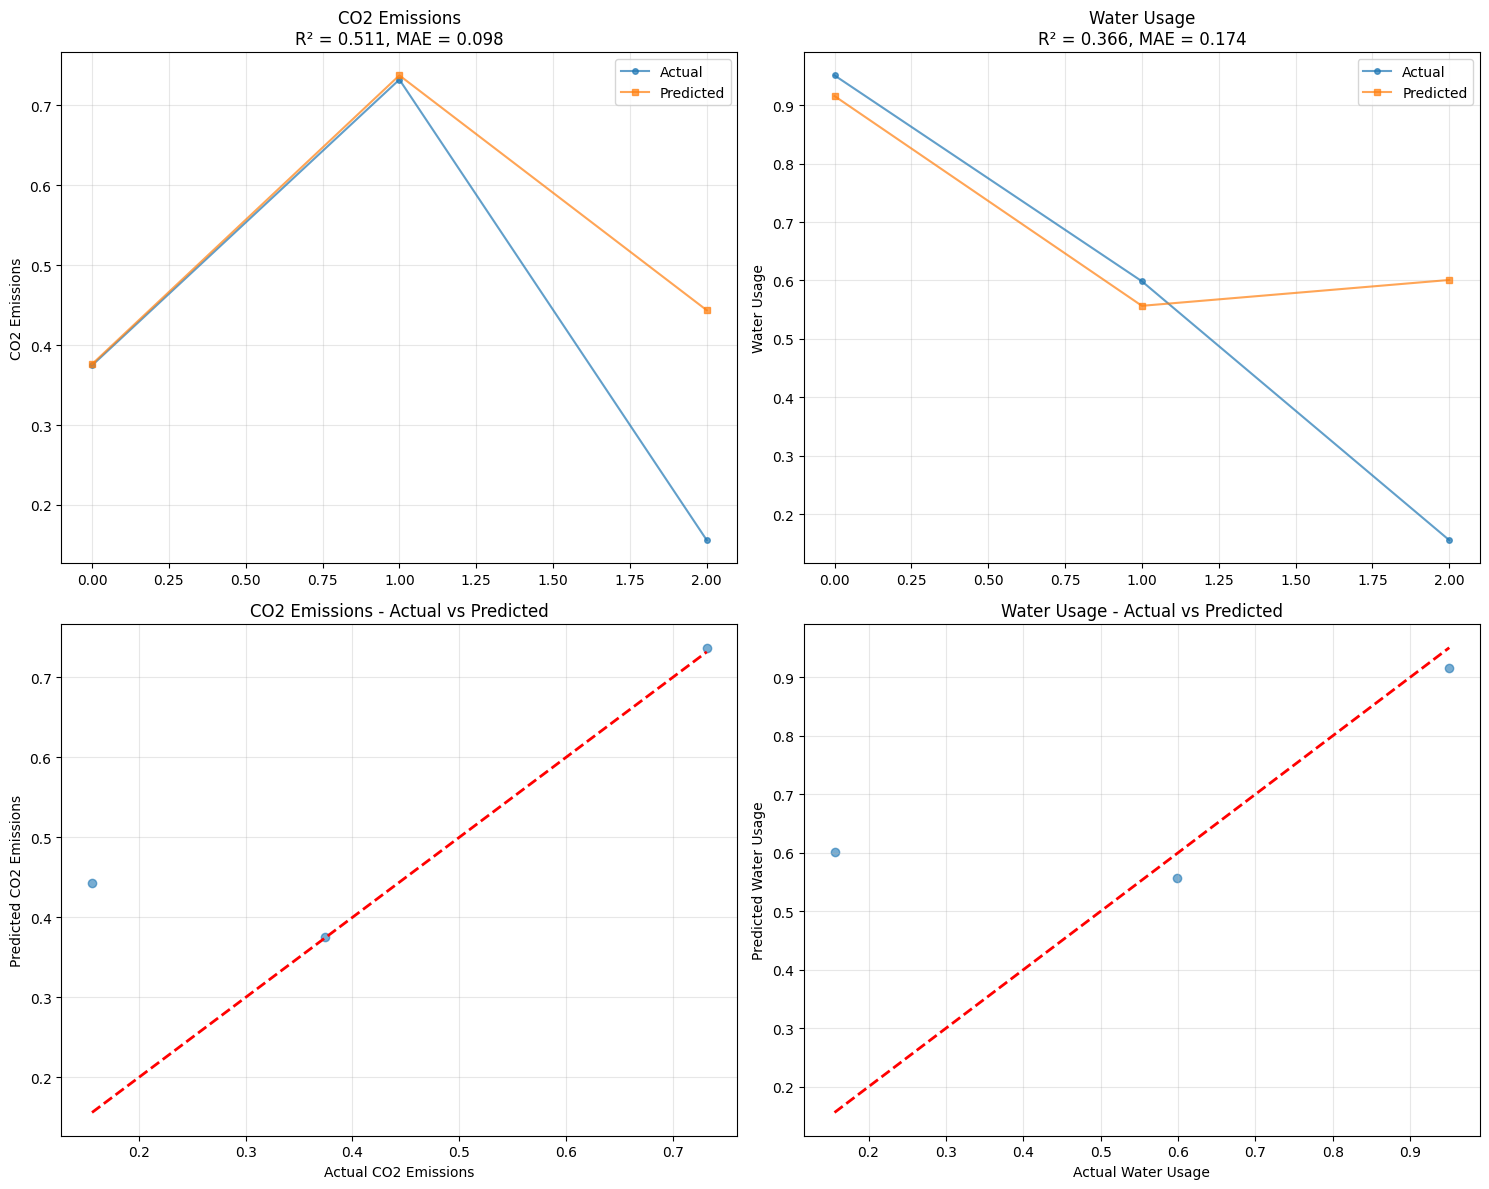

💾 Saving model...
✅ Model saved as 'multimodal_environmental_impact_model.h5'
🎯 Pipeline completed successfully!


C:\Users\ctewa\anaconda3\envs\mynew2\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
# Complete Multimodal Environmental Impact Prediction Pipeline
# ============================================================

import pandas as pd
import numpy as np
import cv2
import os
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# 1. DATA LOADING AND PREPROCESSING
# =================================

print("📊 Loading and preprocessing data...")

# Load farm logs data
logs_df = pd.read_csv('../data/logs/farm_logs.csv')
cat_features = ['farm_id', 'crop_type', 'activity']
num_features = ['fertilizer_used', 'equipment_hours']

# Encode categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_cat = encoder.fit_transform(logs_df[cat_features])

# Normalize numerical features
scaler = MinMaxScaler()
scaled_num = scaler.fit_transform(logs_df[num_features])

# Combine features
X_logs = np.hstack([encoded_cat, scaled_num])

# Load sensor data
sensor_df = pd.read_csv('../data/sensor/sensor_data.csv', parse_dates=['timestamp'])
n_samples = len(sensor_df['farm_id'].unique())
time_steps = 10
features = ['temperature', 'humidity', 'soil_moisture']

# Create sensor sequences
sensor_sequences = []
for i in range(n_samples):
    seq = sensor_df[sensor_df['farm_id'] == i][features].values
    if len(seq) < time_steps:
        pad = np.zeros((time_steps - len(seq), len(features)))
        seq = np.vstack((seq, pad))
    else:
        seq = seq[:time_steps]
    sensor_sequences.append(seq)

X_sensor_lstm = np.array(sensor_sequences)

# Load satellite images
X_images = []
for i in range(n_samples):
    img_path = f'../data/satellite/img_{i:03d}.jpg'
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image = image.astype(np.float32) / 255.0
        X_images.append(image.reshape(128, 128, 1))
    else:
        print(f"Missing image: {img_path}")
        X_images.append(np.zeros((128, 128, 1)))

X_images = np.array(X_images)

# Create target variables (CO2 emissions and water usage)
np.random.seed(42)
y = np.random.rand(n_samples, 2)

# Ensure consistent sample sizes
min_samples = min(len(X_logs), len(X_sensor_lstm), len(X_images))
X_logs = X_logs[:min_samples]
X_sensor_lstm = X_sensor_lstm[:min_samples]
X_images = X_images[:min_samples]
y = y[:min_samples]

print(f"✅ Data shapes - X_logs: {X_logs.shape}, X_sensor: {X_sensor_lstm.shape}, X_images: {X_images.shape}, y: {y.shape}")

# 2. MODEL ARCHITECTURE
# =====================

print("🧠 Building multimodal model...")

# Logs branch (tabular data)
input_logs = Input(shape=(X_logs.shape[1],), name='logs_input')
x1 = Dense(64, activation='relu')(input_logs)
x1 = Dense(32, activation='relu')(x1)

# Sensor branch (time series data)
input_sensor = Input(shape=(X_sensor_lstm.shape[1], X_sensor_lstm.shape[2]), name='sensor_input')
x2 = LSTM(64, return_sequences=False)(input_sensor)
x2 = Dense(32, activation='relu')(x2)

# Image branch (satellite data)
input_images = Input(shape=(128, 128, 1), name='image_input')
x3 = Conv2D(32, (3,3), activation='relu')(input_images)
x3 = MaxPooling2D((2,2))(x3)
x3 = Conv2D(64, (3,3), activation='relu')(x3)
x3 = MaxPooling2D((2,2))(x3)
x3 = Flatten()(x3)
x3 = Dense(32, activation='relu')(x3)

# Merge all branches
merged = Concatenate()([x1, x2, x3])
out = Dense(64, activation='relu')(merged)
out = Dense(2, activation='linear')(out)  # Predicting [CO2, Water Usage]

# Compile model
model = Model(inputs=[input_logs, input_sensor, input_images], outputs=out)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

print("✅ Model built successfully!")
model.summary()

# 3. MODEL TRAINING
# =================

print("🚀 Training model...")

history = model.fit(
    [X_logs, X_sensor_lstm, X_images],
    y,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

# 4. MODEL EVALUATION AND PREDICTION
# ==================================

print("📈 Making predictions...")

# Generate predictions
y_pred = model.predict([X_logs, X_sensor_lstm, X_images])

# Calculate metrics
r2_co2 = r2_score(y[:, 0], y_pred[:, 0])
r2_water = r2_score(y[:, 1], y_pred[:, 1])
mae_co2 = mean_absolute_error(y[:, 0], y_pred[:, 0])
mae_water = mean_absolute_error(y[:, 1], y_pred[:, 1])

print(f"📊 Model Performance:")
print(f"   CO2 Emissions - R²: {r2_co2:.3f}, MAE: {mae_co2:.3f}")
print(f"   Water Usage    - R²: {r2_water:.3f}, MAE: {mae_water:.3f}")

# 5. VISUALIZATION
# ================

print("🎨 Creating visualizations...")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# CO2 Emissions - Time series
axes[0,0].plot(y[:, 0], 'o-', label='Actual', alpha=0.7, markersize=4)
axes[0,0].plot(y_pred[:, 0], 's-', label='Predicted', alpha=0.7, markersize=4)
axes[0,0].set_title(f'CO2 Emissions\nR² = {r2_co2:.3f}, MAE = {mae_co2:.3f}')
axes[0,0].set_ylabel('CO2 Emissions')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Water Usage - Time series
axes[0,1].plot(y[:, 1], 'o-', label='Actual', alpha=0.7, markersize=4)
axes[0,1].plot(y_pred[:, 1], 's-', label='Predicted', alpha=0.7, markersize=4)
axes[0,1].set_title(f'Water Usage\nR² = {r2_water:.3f}, MAE = {mae_water:.3f}')
axes[0,1].set_ylabel('Water Usage')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# CO2 Emissions - Scatter plot
axes[1,0].scatter(y[:, 0], y_pred[:, 0], alpha=0.6)
axes[1,0].plot([y[:, 0].min(), y[:, 0].max()], [y[:, 0].min(), y[:, 0].max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual CO2 Emissions')
axes[1,0].set_ylabel('Predicted CO2 Emissions')
axes[1,0].set_title('CO2 Emissions - Actual vs Predicted')
axes[1,0].grid(True, alpha=0.3)

# Water Usage - Scatter plot
axes[1,1].scatter(y[:, 1], y_pred[:, 1], alpha=0.6)
axes[1,1].plot([y[:, 1].min(), y[:, 1].max()], [y[:, 1].min(), y[:, 1].max()], 'r--', lw=2)
axes[1,1].set_xlabel('Actual Water Usage')
axes[1,1].set_ylabel('Predicted Water Usage')
axes[1,1].set_title('Water Usage - Actual vs Predicted')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('multimodal_prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. MODEL SAVING
# ===============

print("💾 Saving model...")
model.save("multimodal_environmental_impact_model.h5")
print("✅ Model saved as 'multimodal_environmental_impact_model.h5'")

print("🎯 Pipeline completed successfully!")